* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
model.objective = "BIOMASS_RT_CLIM" 



Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [2]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1] # the fifth glc uptake value was calculated

# medium = model.medium
# medium["EX_glc__D_e"] = glucose_uptakes[3]
# model.medium = medium
solution = model.optimize()

In [13]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_l', 'nadph_m', 'nadph_r', 'nadph_rm','nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r', 'nadh_rm']
atps = ['atp_c', 'atp_m', 'atp_n', 'atp_r', 'atp_en', 'atp_gm', 'atp_l', 'atp_rm', 'atp_vm', 'atp_x'] 


In [4]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, glucose_uptake):
    cofactor_fluxes = pd.DataFrame() 

    medium = model.medium
    medium["EX_glc__D_e"] = glucose_uptake
    model.medium = medium
        
    solution = model.optimize()
    biomass_GR = solution.objective_value
    print(f'Biomass growth rate: {biomass_GR}')
    for metabolite in cofactor_list:
        cofactor_fluxes = pd.concat([cofactor_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux, getattr(model.metabolites, metabolite).summary().producing_flux])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column
    else:
        print('error')

    return cofactor_fluxes, biomass_GR

In [5]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold, producing_fluxes_chart = True): # threshold shows the percent of the flux for including in others sector on pie chart 
        
    if producing_fluxes_chart: 
        # The three lines below are for grouping together reactions with low fluxes
        producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]
        producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other'
        producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')['percent'].sum().reset_index() 
     
        y = producing_cofactor_fluxes_draw['percent']
        labels = producing_cofactor_fluxes_draw['reaction']
        pie_chart = plt.pie(y, labels = labels, autopct='%1.1f%%') #, figsize=(5, 5)
        plt.title(title)
        plt.show()
        
    else:
        # The three lines below are for grouping together reactions with low fluxes
        consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
        consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other'
        consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')['percent'].sum().reset_index()
        
        y = consuming_cofactor_fluxes_draw['percent']
        labels = consuming_cofactor_fluxes_draw['reaction']
        pie_chart = plt.pie(y, labels = labels, autopct='%1.1f%%')  
        plt.title(title)
        plt.show()  
    return pie_chart

In [6]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadphs, glucose_uptakes[5])
print(biomass_GR_highest)
nadph_fluxes_highest_GR


Biomass growth rate: 0.03397202996173056
SUM produced: 0.5550688435005702, SUM consumed: -0.5550688434974671
0.03397202996173056
Biomass growth rate: 0.2345730383583788
SUM produced: 3.8326878100800315, SUM consumed: -3.83268780992794
0.2345730383583788


,flux,reaction,percent
GND_c,1.691460,GND_c,0.441325
G6PDH2i_c,1.691460,G6PDH2i_c,0.441325
ICDHyi_m,0.242928,ICDHyi_m,0.063383
MTHFD_c,0.074771,MTHFD_c,0.019509
NADPHt_c_rm,0.033339,NADPHt_c_rm,0.008699
...,...,...,...
AGPRi_m,-0.074956,AGPRi_m,0.019557
ASAD_c,-0.116897,ASAD_c,0.030500
KARA1i_m,-0.142283,KARA1i_m,0.037124
HMGCOAR_c,-0.419783,HMGCOAR_c,0.109527


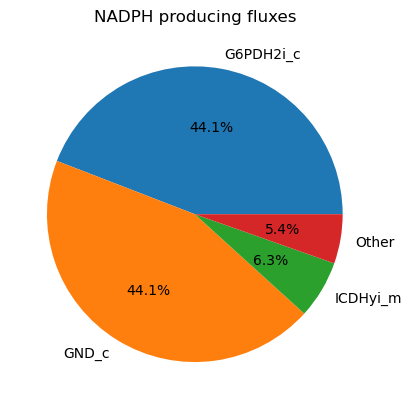

([<matplotlib.patches.Wedge at 0x1bddc79d940>,
 [Text(0.20162028124143974, 1.0813645371437528, 'G6PDH2i_c'),
  Text(-0.5777665852466457, -0.9360479544192332, 'GND_c'),
  Text(0.9444908488053887, -0.5638590573209555, 'ICDHyi_m'),
  Text(1.0842282661961886, -0.18560459795276324, 'Other')],
 [Text(0.10997469885896712, 0.5898352020784106, '44.1%'),
  Text(-0.31514541013453395, -0.5105716115013998, '44.1%'),
  Text(0.5151768266211211, -0.3075594858114302, '6.3%'),
  Text(0.5913972361070119, -0.10123887161059812, '5.4%')])

In [7]:
# Make a pie plot for napdh producing fluxes
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = 'NADPH producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold,  True)
producing_nadph_fluxes_lowest_GR_pie_chart

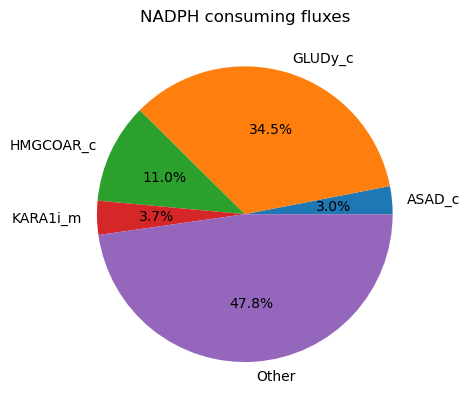

([<matplotlib.patches.Wedge at 0x1bddc7aa540>,
 [Text(1.0949542098670788, 0.10523914810735116, 'ASAD_c'),
  Text(0.3190204373739451, 1.0527231167490039, 'GLUDy_c'),
  Text(-0.9970741762769157, 0.46458915936740297, 'HMGCOAR_c'),
  Text(-1.0996651234149397, -0.027140676940815716, 'KARA1i_m'),
  Text(0.07765212608286247, -1.0972557346921508, 'Other')],
 [Text(0.5972477508365884, 0.057403171694918806, '3.0%'),
  Text(0.17401114765851547, 0.5742126091358203, '34.5%'),
  Text(-0.5438586416055904, 0.25341226874585615, '11.0%'),
  Text(-0.5998173400445125, -0.014804005604081297, '3.7%'),
  Text(0.04235570513610679, -0.5985031280139003, '47.8%')])

In [8]:
# Make a pie plot for nadph consuming fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADPH consuming fluxes'
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [9]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[0])
print(biomass_GR_lowest)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(nadhs, glucose_uptakes[5])
print(biomass_GR_highest)
nadh_fluxes_highest_GR


Biomass growth rate: 0.03397202996173044
SUM produced: 3.006673324958395, SUM consumed: -3.0066733249583946
0.03397202996173044
Biomass growth rate: 0.2345730383583788
SUM produced: 18.52002418956608, SUM consumed: -18.520024189566076
0.2345730383583788


,flux,reaction,percent
MDH_m,6.260721,MDH_m,0.338051
GAPD_c,4.571854,GAPD_c,0.246860
PDH_m,3.293873,PDH_m,0.177855
ICDHx_m,1.712103,ICDHx_m,0.092446
GCC2c_m,1.675565,GCC2c_m,0.090473
ME1_m,0.362208,ME1_m,0.019558
PGCD_c,0.224000,PGCD_c,0.012095
IPMD_c,0.074283,IPMD_c,0.004011
NADHt_c_rm,0.064303,NADHt_c_rm,0.003472
SACCD2_c,0.060929,SACCD2_c,0.003290


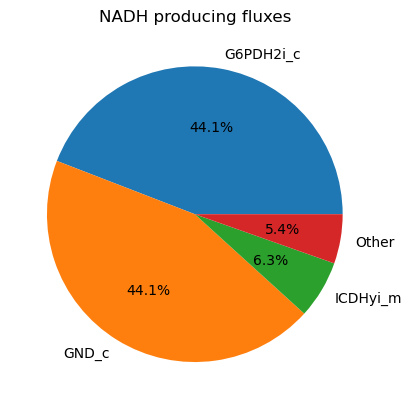

([<matplotlib.patches.Wedge at 0x1bddc6b7c20>,
 [Text(0.20162028124143974, 1.0813645371437528, 'G6PDH2i_c'),
  Text(-0.5777665852466457, -0.9360479544192332, 'GND_c'),
  Text(0.9444908488053887, -0.5638590573209555, 'ICDHyi_m'),
  Text(1.0842282661961886, -0.18560459795276324, 'Other')],
 [Text(0.10997469885896712, 0.5898352020784106, '44.1%'),
  Text(-0.31514541013453395, -0.5105716115013998, '44.1%'),
  Text(0.5151768266211211, -0.3075594858114302, '6.3%'),
  Text(0.5913972361070119, -0.10123887161059812, '5.4%')])

In [15]:
# Make a pie plot for nadh producing fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'NADH producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, True)
producing_nadph_fluxes_lowest_GR_pie_chart

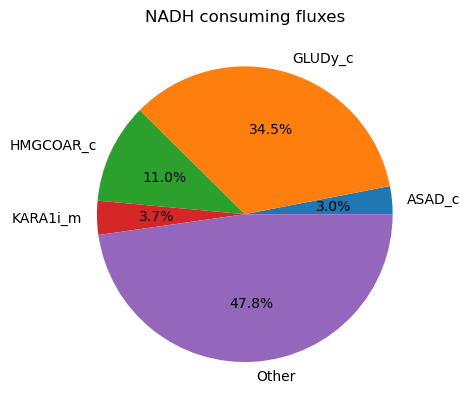

([<matplotlib.patches.Wedge at 0x1bdcf06ca10>,
 [Text(1.0949542098670788, 0.10523914810735116, 'ASAD_c'),
  Text(0.3190204373739451, 1.0527231167490039, 'GLUDy_c'),
  Text(-0.9970741762769157, 0.46458915936740297, 'HMGCOAR_c'),
  Text(-1.0996651234149397, -0.027140676940815716, 'KARA1i_m'),
  Text(0.07765212608286247, -1.0972557346921508, 'Other')],
 [Text(0.5972477508365884, 0.057403171694918806, '3.0%'),
  Text(0.17401114765851547, 0.5742126091358203, '34.5%'),
  Text(-0.5438586416055904, 0.25341226874585615, '11.0%'),
  Text(-0.5998173400445125, -0.014804005604081297, '3.7%'),
  Text(0.04235570513610679, -0.5985031280139003, '47.8%')])

In [16]:
# Make a pie plot for nadh consuming fluxes
threshold = 0.02 
title = 'NADH consuming fluxes'
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [14]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR, biomass_GR_lowest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[0])
print(biomass_GR_lowest)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR, biomass_GR_highest = cofactor_all_rxn_fluxes(atps, glucose_uptakes[5])
print(biomass_GR_highest)
atp_fluxes_highest_GR

Biomass growth rate: 0.03397202996173044
SUM produced: 16.251071457673774, SUM consumed: -16.251071368422256
0.03397202996173044
Biomass growth rate: 0.2345730383583788
SUM produced: 98.16999496917732, SUM consumed: -98.16999496910132
0.2345730383583788


,flux,reaction,percent
ADPATPt_c_m,44.646580,ADPATPt_c_m,0.454788
ATPS_m,43.033174,ATPS_m,0.438354
PGK_c,4.571854,PGK_c,0.046571
PYK_c,4.229565,PYK_c,0.043084
SUCOAS_m,1.659428,SUCOAS_m,0.016904
...,...,...,...
ACITL_c,-1.293863,ACITL_c,0.013180
PFK_c,-1.490907,PFK_c,0.015187
HEX1_c,-3.100000,HEX1_c,0.031578
BIOMASS_RT_CLIM,-39.116301,BIOMASS_RT_CLIM,0.398455


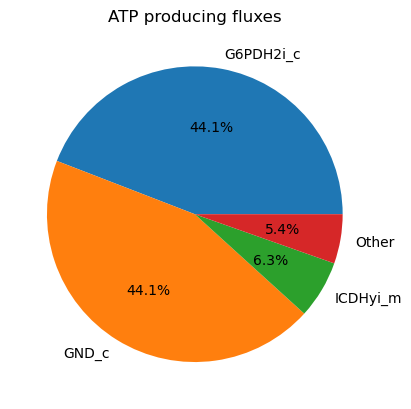

([<matplotlib.patches.Wedge at 0x1bdcf0139b0>,
 [Text(0.20162028124143974, 1.0813645371437528, 'G6PDH2i_c'),
  Text(-0.5777665852466457, -0.9360479544192332, 'GND_c'),
  Text(0.9444908488053887, -0.5638590573209555, 'ICDHyi_m'),
  Text(1.0842282661961886, -0.18560459795276324, 'Other')],
 [Text(0.10997469885896712, 0.5898352020784106, '44.1%'),
  Text(-0.31514541013453395, -0.5105716115013998, '44.1%'),
  Text(0.5151768266211211, -0.3075594858114302, '6.3%'),
  Text(0.5913972361070119, -0.10123887161059812, '5.4%')])

In [17]:
# Make a pie plot for atp producing fluxes
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = 'ATP producing fluxes'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title,  threshold, True)
producing_nadph_fluxes_lowest_GR_pie_chart

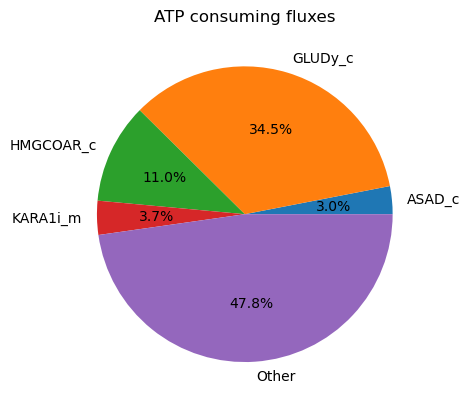

([<matplotlib.patches.Wedge at 0x1bddd0a37d0>,
 [Text(1.0949542098670788, 0.10523914810735116, 'ASAD_c'),
  Text(0.3190204373739451, 1.0527231167490039, 'GLUDy_c'),
  Text(-0.9970741762769157, 0.46458915936740297, 'HMGCOAR_c'),
  Text(-1.0996651234149397, -0.027140676940815716, 'KARA1i_m'),
  Text(0.07765212608286247, -1.0972557346921508, 'Other')],
 [Text(0.5972477508365884, 0.057403171694918806, '3.0%'),
  Text(0.17401114765851547, 0.5742126091358203, '34.5%'),
  Text(-0.5438586416055904, 0.25341226874585615, '11.0%'),
  Text(-0.5998173400445125, -0.014804005604081297, '3.7%'),
  Text(0.04235570513610679, -0.5985031280139003, '47.8%')])

In [18]:
# Make a pie plot for atp consuming fluxes
title = 'ATP consuming fluxes'
threshold = 0.02 
consuming_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold, False)
consuming_nadph_fluxes_lowest_GR_pie_chart

In [20]:
# Get cofactor data to excel
with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_cofactor_fluxes.xlsx') as excel_writer:
    nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
    nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
    nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
    nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
    atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
    atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)

    